#### Author
Victor Aleksandrin

#### Reference
[Notion ticket](https://www.notion.so/a74951e4e815480584dea7d61ddce6cc?v=dbfdb1207d0e451b827d3c5041ed0cfd&p=86e3d7a76b57483d88bf96ade01cc7c1)

#### Idea
Calibrate Bert output probabilities. 

#### Data
- 4500 cryptonews titles labeled as positive, neutral or negative – zipped pwd-protected [CSV](https://drive.google.com/file/d/1Apr3YPZVf0kOJ5Pc1RYDoQxTdjJPbnt4/view?usp=sharing) (not to be shared outside of the project!)
- `/artifacts/data/20220417_Batch_353286_trial1_results.csv` and `/artifacts/data/20220417_Batch_353289_trial2_results.csv` – manually labelled samples

#### Results
- As we can see from the calibration curves base model is highly uncalibrated
- Isotonic regression and label smoothing alleviate the problem a bit and improve accuracy

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import yaml

from sklearn.calibration import CalibratedClassifierCV

from bert_calibartion_utils.dataset import split_train_val
from bert_calibartion_utils.utils import (
    get_probs_gt_by_class, plot_calibration_curves, plot_distributions
)
from bert_calibartion_utils.sklearn_estimator import BertWrapper
from bert_calibartion_utils.data import read_data
from sklearn.metrics import accuracy_score
from pytorch_lightning import seed_everything

import torch

import warnings
warnings.filterwarnings('ignore')

import logging
logging.disable(logging.INFO)
logging.disable(logging.WARNING)

seed_everything(42)

42

### Read data

In [2]:
DATA_PATH = "/artifacts/data"

In [3]:
dataset = read_data(DATA_PATH)

In [4]:
dataset.head()

,title,sentiment,label
2313,Bitcoin Cash Price Analysis: BCH/USD Recoverin...,Positive,2
315,"Bitcoin Transactions Will Double By 2017, Rese...",Positive,2
2328,Bitcoin Faces Extinction Without Core Developm...,Negative,0
472,Philippine Bitcoin Wallet App Coins.ph Reaches...,Positive,2
534,Bitcoin Price Retreats 2% as Crypto Market Con...,Negative,0


### Load model

In [5]:
cfg_str = """
epochs: 3
train_batch_size: 8
val_batch_size: 16
seed: 42
device: cuda
num_workers: 4
scheduler_interval: step
scheduler_frequency: 1

model_name: &model_name distilbert-base-uncased

tokenizer:
    class: transformers.DistilBertTokenizerFast
    params:
        pretrained_model_name_or_path: *model_name
    call_params:
        truncation: True
        padding: True
        return_tensors: pt

model:
    class: transformers.DistilBertForSequenceClassification
    params:
        pretrained_model_name_or_path: *model_name
        num_labels: 3

criterion:
    class: torch.nn.CrossEntropyLoss
    params:
        reduction: "mean"
        label_smoothing: 0.0

optimizer:
    class: transformers.AdamW
    params:
        lr: 0.00005
        weight_decay: 0.001

scheduler:
    class: torch.optim.lr_scheduler.CosineAnnealingLR
    params:
        T_max: -1
        eta_min: 0.000001
        last_epoch: -1
"""

In [6]:
cfg = yaml.safe_load(cfg_str)

### Task description

Bert gives overconfident class probabilities estimates. To address this problem we'll firstly try to regularize the model using label smoothing, then we'll calibrate it using sigmoid or isotonic regressor.


#### Steps

1. Split dataset on train data (80%) and validation data(20%).
2. [Base model](#Train-base-model)
3. [Base model with label smoothing](#Train-base-model-with-label-smoothing)
4. [Calibrated model (sigmoid regressor)](#Train-calibrated-model-(sigmoid-regressor))
5. [Calibrated model (isotonic regressor)](#Train-calibrated-model-(isotonic-regressor))

#### References
- [Probability calibration](https://scikit-learn.org/stable/modules/calibration.html)

### Split data

In [7]:
train_data, val_data, train_labels, val_labels = split_train_val(
    dataset["title"], 
    dataset["sentiment"], 
    test_size=0.2
)

### Train base model

In [8]:
model = BertWrapper(cfg)

In [9]:
model.fit(train_data, train_labels)

Training: 0it [00:00, ?it/s]

BertWrapper(cfg={'criterion': {'class': 'torch.nn.CrossEntropyLoss',
                               'params': {'label_smoothing': 0.0,
                                          'reduction': 'mean'}},
                 'device': 'cuda', 'epochs': 3,
                 'model': {'class': 'transformers.DistilBertForSequenceClassification',
                           'params': {'num_labels': 3,
                                      'pretrained_model_name_or_path': 'distilbert-base-uncased'}},
                 'model_name': 'distilbert-base-uncased', 'num_workers...
                               'params': {'T_max': 1428, 'eta_min': 1e-06,
                                          'last_epoch': -1}},
                 'scheduler_frequency': 1, 'scheduler_interval': 'step',
                 'seed': 42,
                 'tokenizer': {'call_params': {'padding': True,
                                               'return_tensors': 'pt',
                                               'truncation': 

#### Evaluate base model

In [10]:
val_predict = model.predict(val_data)

In [11]:
accuracy_score(val_labels, val_predict)

0.7867647058823529

In [12]:
val_predict_probs = model.predict_proba(val_data)

In [13]:
probs_gt_by_class = get_probs_gt_by_class(val_predict_probs, val_labels)

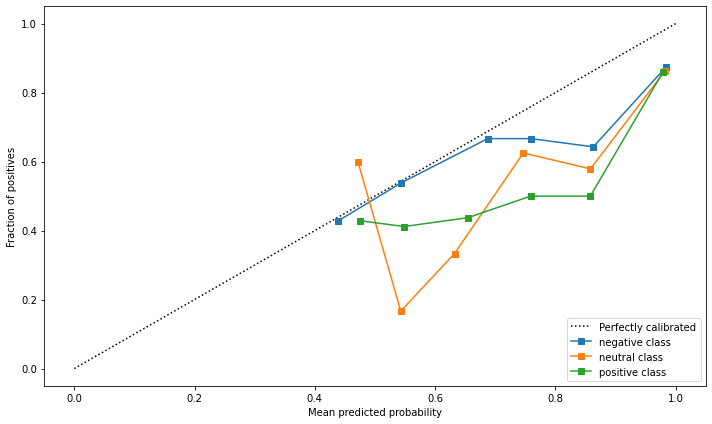

In [14]:
f = plot_calibration_curves(probs_gt_by_class)

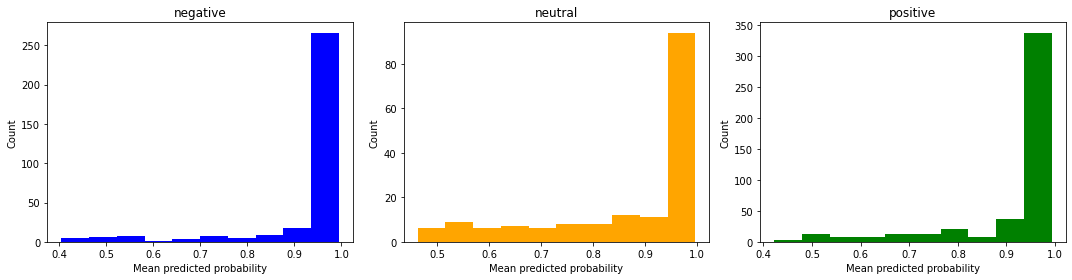

In [15]:
f = plot_distributions(probs_gt_by_class)

### Train base model with label smoothing

In [16]:
cfg_label_smoothing = deepcopy(cfg)

In [17]:
cfg_label_smoothing["criterion"]["params"]["label_smoothing"] = 0.3

In [18]:
model = BertWrapper(cfg_label_smoothing)

In [19]:
model.fit(train_data, train_labels)

Training: 0it [00:00, ?it/s]

BertWrapper(cfg={'criterion': {'class': 'torch.nn.CrossEntropyLoss',
                               'params': {'label_smoothing': 0.3,
                                          'reduction': 'mean'}},
                 'device': 'cuda', 'epochs': 3,
                 'model': {'class': 'transformers.DistilBertForSequenceClassification',
                           'params': {'num_labels': 3,
                                      'pretrained_model_name_or_path': 'distilbert-base-uncased'}},
                 'model_name': 'distilbert-base-uncased', 'num_workers...
                               'params': {'T_max': 1428, 'eta_min': 1e-06,
                                          'last_epoch': -1}},
                 'scheduler_frequency': 1, 'scheduler_interval': 'step',
                 'seed': 42,
                 'tokenizer': {'call_params': {'padding': True,
                                               'return_tensors': 'pt',
                                               'truncation': 

#### Evaluate base model with label smoothing

In [20]:
val_predict = model.predict(val_data)

In [21]:
accuracy_score(val_labels, val_predict)

0.7899159663865546

In [22]:
val_predict_probs = model.predict_proba(val_data)

In [23]:
probs_gt_by_class = get_probs_gt_by_class(val_predict_probs, val_labels)

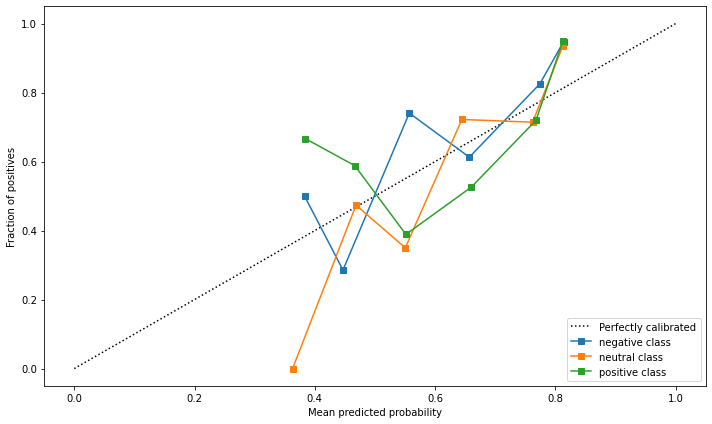

In [24]:
f = plot_calibration_curves(probs_gt_by_class)

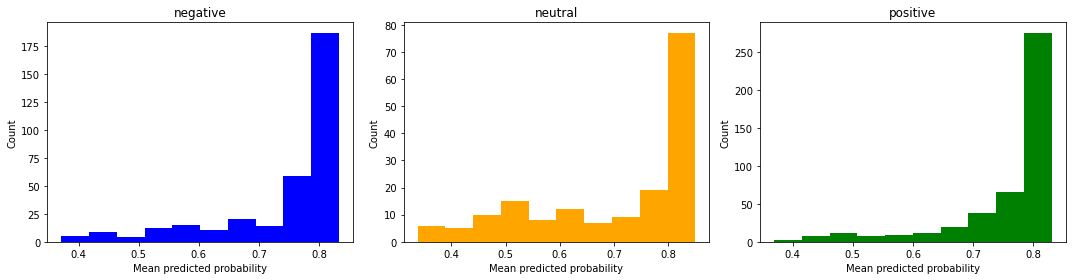

In [25]:
f = plot_distributions(probs_gt_by_class)

### Train calibrated model (sigmoid regressor)

In [26]:
calibrated_model = CalibratedClassifierCV(
    base_estimator=model, cv=3, method="sigmoid", ensemble=True)

In [27]:
calibrated_model.fit(train_data, train_labels)

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

CalibratedClassifierCV(base_estimator=BertWrapper(cfg={'criterion': {'class': 'torch.nn.CrossEntropyLoss',
                                                                     'params': {'label_smoothing': 0.3,
                                                                                'reduction': 'mean'}},
                                                       'device': 'cuda',
                                                       'epochs': 3,
                                                       'model': {'class': 'transformers.DistilBertForSequenceClassification',
                                                                 'params': {'num_labels': 3,
                                                                            'pretrained_model_name_or_path': 'distilbert-base-uncased'}},
                                                       'model_name':...
                                                                     'params': {'T_max': 1428,
                     

#### Evalutate calibrated model (sigmoid regressor)

In [28]:
val_predict = calibrated_model.predict(val_data)

In [29]:
accuracy_score(val_labels, val_predict)

0.8046218487394958

In [30]:
val_predict_probs = calibrated_model.predict_proba(val_data)

In [31]:
probs_gt_by_class = get_probs_gt_by_class(val_predict_probs, val_labels)

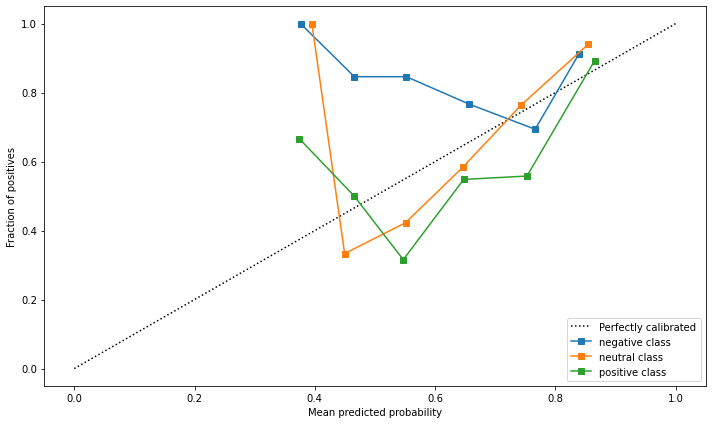

In [32]:
f = plot_calibration_curves(probs_gt_by_class)

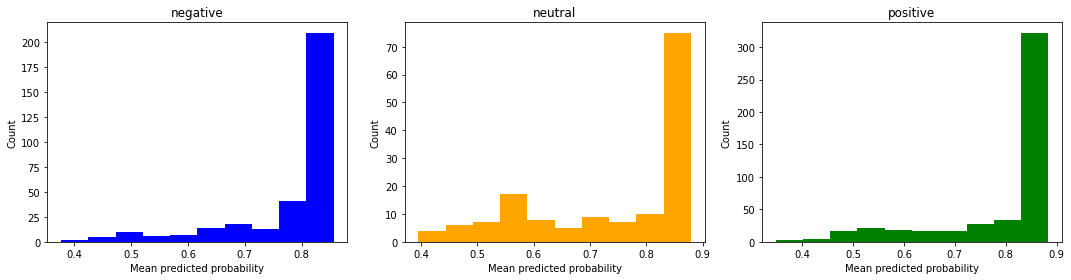

In [33]:
f = plot_distributions(probs_gt_by_class)

### Train calibrated model (isotonic regressor)

In [34]:
calibrated_model = CalibratedClassifierCV(
    base_estimator=model, cv=3, method="isotonic", ensemble=True)

In [35]:
calibrated_model.fit(train_data, train_labels)

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

CalibratedClassifierCV(base_estimator=BertWrapper(cfg={'criterion': {'class': 'torch.nn.CrossEntropyLoss',
                                                                     'params': {'label_smoothing': 0.3,
                                                                                'reduction': 'mean'}},
                                                       'device': 'cuda',
                                                       'epochs': 3,
                                                       'model': {'class': 'transformers.DistilBertForSequenceClassification',
                                                                 'params': {'num_labels': 3,
                                                                            'pretrained_model_name_or_path': 'distilbert-base-uncased'}},
                                                       'model_name':...
                                                                                'eta_min': 1e-06,
                  

#### Evaluate calibrated model (isotonic regressor)

In [42]:
val_predict = calibrated_model.predict(val_data)

In [43]:
accuracy_score(val_labels, val_predict)

0.8046218487394958

In [44]:
val_predict_probs = calibrated_model.predict_proba(val_data)

In [45]:
probs_gt_by_class = get_probs_gt_by_class(val_predict_probs, val_labels)

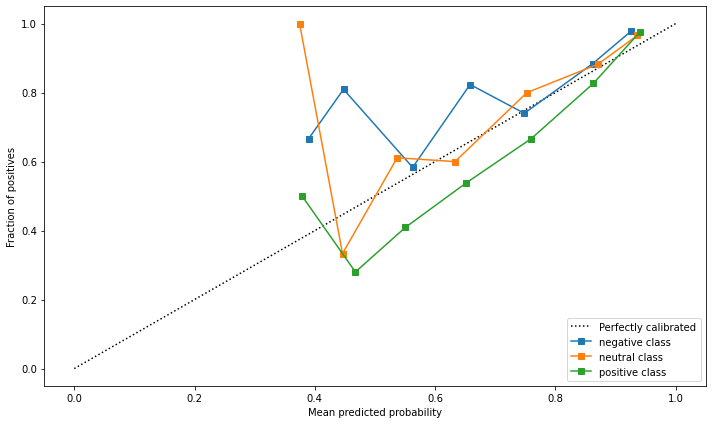

In [46]:
f = plot_calibration_curves(probs_gt_by_class)

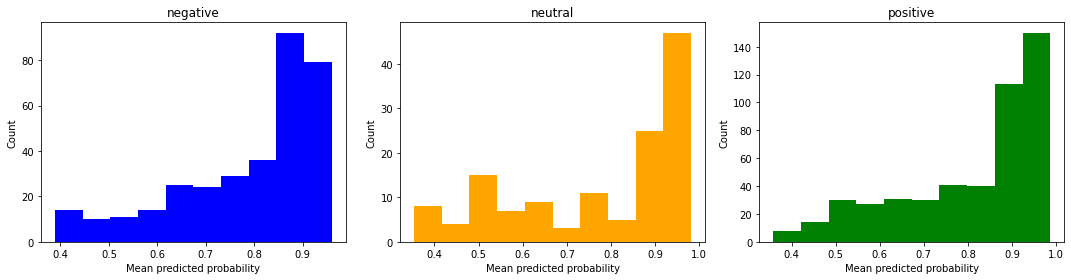

In [47]:
f = plot_distributions(probs_gt_by_class)

### Acc comparison

In [50]:
table = pd.DataFrame(
    {
        "model": [
            "base", 
            "base, label smoothing", 
            "base, label smoothing, sigmoid regressor",
            "base, label smoothing, isotonic regressor"
        ],
        "validation acc": [78.6, 78.9, 80.4, 80.4]
    }
)

In [51]:
table

,model,validation acc
0,base,78.6
1,"base, label smoothing",78.9
2,"base, label smoothing, sigmoid regressor",80.4
3,"base, label smoothing, isotonic regressor",80.4
